In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:


#input_dir = 'hist-pdf-toy-study-1d-1a-perfect'
#input_dir = 'hist-pdf-toy-study-1d-1a-goodres'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1b-mediumbad'


#input_dir = 'bootstrap-toy-study8a-1d-1d-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-1d-goodres'
#input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'
input_dir = 'bootstrap-toy-study8a-1d-1d-mediumbad'






#input_dir = 'bootstrap-toy-study8a-1d-2a-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-2a-nominal-resolution'


#input_dir = 'bootstrap-toy-study8a-1d-2a'




hist_nbins = 20
#hist_nbins = 40

hist_xlow = -3.
hist_xhigh = 3.

#hist_xlow = -2.
#hist_xhigh = 2.




with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (100000, 1)
 shape of true_pts:   (10000, 1)





In [3]:


with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)

main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

print('\n\n')
print(' shape of main_sample_omnifold_weights: %s' % str(main_sample_omnifold_weights.shape))
print('\n\n')





 shape of main_sample_omnifold_weights: (100000,)





In [4]:
main_sample_omnifold_weights

array([0.1166674 , 0.08762885, 0.12254042, ..., 0.09664661, 0.13070659,
       0.11742485])

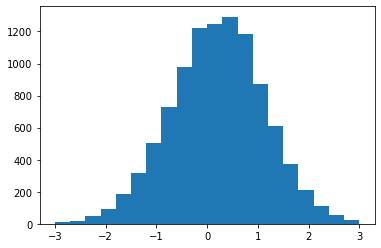

In [5]:
unfolded_hist,hist_bin_edges,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )

In [6]:
hist_bin_edges

array([-3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ,
        0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ])

In [7]:
hist_bin_centers = np.zeros( hist_nbins )
for bi in range(hist_nbins) :
    hist_bin_centers[bi] = 0.5*(hist_bin_edges[bi] + hist_bin_edges[bi+1])

In [8]:
hist_bin_centers

array([-2.85, -2.55, -2.25, -1.95, -1.65, -1.35, -1.05, -0.75, -0.45,
       -0.15,  0.15,  0.45,  0.75,  1.05,  1.35,  1.65,  1.95,  2.25,
        2.55,  2.85])

In [9]:
bin_width = hist_bin_edges[1] - hist_bin_edges[0]

In [10]:
weight_sum = np.sum( main_sample_omnifold_weights )
print('\n\n Sum of ominfold weights:  %.3f' % weight_sum )



 Sum of ominfold weights:  10096.306


In [11]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [12]:
mean_cov = calc_mean_cov( main_sample_omnifold_weights, 0, 0 )

In [13]:
mean_cov

{'mean_x1': 0.20977557486027862,
 'mean_x2': 0.20977557486027862,
 'cov_x1x2': 0.8580299422606645,
 'rms1': 0.9262990566014113}

In [14]:
dummy_weights = np.ones( len(train_pts))
dummy_weights = (len(true_pts) / len(train_pts)) * dummy_weights

In [15]:
dummy_weights

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [16]:
dummy_weights.shape

(100000,)

<function matplotlib.pyplot.show(close=None, block=None)>

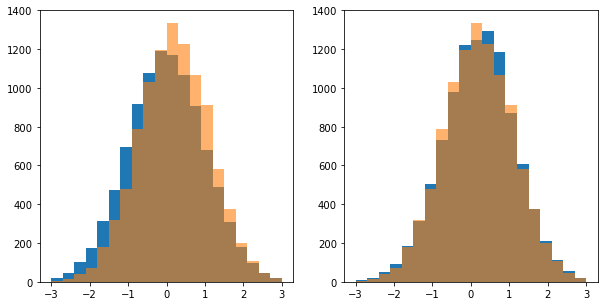

In [17]:
fig,ax = plt.subplots( 1, 2, figsize=(2*5,5))

ax[0].hist( train_pts[:,0], bins=hist_nbins, weights=dummy_weights, range=[hist_xlow, hist_xhigh] )
ax[0].hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh], alpha=0.6 )

ax[1].hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )
ax[1].hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh], alpha=0.6 )

plt.show

In [18]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 1000 bootstrap samples.




 boot   0 weights: [0.1185423  0.0876058  0.11989613 ... 0.09525693 0.11911066 0.1185365 ]
 boot   1 weights: [0.11564698 0.09451943 0.12074247 ... 0.10647583 0.11901799 0.1153959 ]
 boot   2 weights: [0.11874784 0.09742378 0.11603869 ... 0.11005162 0.12418104 0.11974426]
 boot   3 weights: [0.11892768 0.0945404  0.1163866  ... 0.1034372  0.1138299  0.11807981]
 boot   4 weights: [0.11718314 0.09504857 0.11905496 ... 0.10284925 0.11915078 0.11765985]
 boot   5 weights: [0.11289311 0.09544735 0.11376688 ... 0.10603421 0.11991099 0.11323348]
 boot   6 weights: [0.12328385 0.09240539 0.11780632 ... 0.09477363 0.12027341 0.12398173]
 boot   7 weights: [0.12101512 0.09247804 0.11432338 ... 0.09469834 0.1186632  0.12070433]
 boot   8 weights: [0.10702791 0.09247025 0.11734179 ... 0.11169339 0.1189453  0.10816886]
 boot   9 weights: [0.11800588 0.10280579 0.11446614 ... 0.0828946  0.12177884 0.11889757]
 boot  10 weights: [0.11439833 0.0970635  0.12024371 ... 0.10242671 0.11523662 0.11380767]

 boot  99 weights: [0.10787029 0.09157192 0.12919672 ... 0.1117721  0.12074829 0.1079729 ]
 boot 100 weights: [0.11267648 0.09653883 0.12310522 ... 0.10340305 0.12357619 0.11394714]
 boot 101 weights: [0.11174296 0.09602893 0.11795902 ... 0.10783088 0.1187932  0.113208  ]
 boot 102 weights: [0.12058619 0.09332855 0.11302399 ... 0.1005536  0.1167376  0.12025319]
 boot 103 weights: [0.10914536 0.09986491 0.12320319 ... 0.10506181 0.12495655 0.11140022]
 boot 104 weights: [0.10498707 0.10218686 0.12391896 ... 0.10999899 0.11807128 0.10558963]
 boot 105 weights: [0.10612611 0.09508561 0.13630611 ... 0.10057208 0.12443851 0.10746026]
 boot 106 weights: [0.12470529 0.09610332 0.1223802  ... 0.1009327  0.12225956 0.12478753]
 boot 107 weights: [0.10044251 0.09773256 0.12100997 ... 0.12780536 0.11429985 0.10157394]
 boot 108 weights: [0.11945538 0.09305356 0.11372078 ... 0.10122759 0.11917831 0.11963106]
 boot 109 weights: [0.10817172 0.09709735 0.12454997 ... 0.10700006 0.12112402 0.10886181]

 boot 208 weights: [0.11053349 0.09449026 0.12545676 ... 0.10743412 0.12563878 0.11115688]
 boot 209 weights: [0.11180944 0.09575753 0.1222793  ... 0.11091892 0.11816479 0.11063301]
 boot 210 weights: [0.11288841 0.09253973 0.12926323 ... 0.10580252 0.11491897 0.11219949]
 boot 211 weights: [0.11295921 0.0911102  0.12417173 ... 0.10721718 0.11482977 0.11284891]
 boot 212 weights: [0.11392443 0.08959478 0.12829272 ... 0.10295089 0.12038487 0.11395884]
 boot 213 weights: [0.1117047  0.0919417  0.13111625 ... 0.09556059 0.12125789 0.11179184]
 boot 214 weights: [0.11265363 0.09658481 0.11524412 ... 0.10336833 0.11962753 0.1146038 ]
 boot 215 weights: [0.10995411 0.09935055 0.11745144 ... 0.09187113 0.11896653 0.11066051]
 boot 216 weights: [0.11907773 0.10326579 0.11110875 ... 0.09615691 0.12385687 0.12096693]
 boot 217 weights: [0.11427427 0.09748934 0.12101451 ... 0.09956359 0.11976401 0.11515958]
 boot 218 weights: [0.11605434 0.09222195 0.11885758 ... 0.09874395 0.12197834 0.11665969]

 boot 307 weights: [0.12086114 0.0941299  0.11731526 ... 0.09110439 0.124546   0.12132225]
 boot 308 weights: [0.1171788  0.09846879 0.11918441 ... 0.09368386 0.12656975 0.11740349]
 boot 309 weights: [0.1162077  0.0940316  0.12342435 ... 0.1054786  0.12123697 0.11618205]
 boot 310 weights: [0.11781403 0.09710867 0.12158583 ... 0.11210546 0.11709143 0.11713086]
 boot 311 weights: [0.11955129 0.09418311 0.12895267 ... 0.0763743  0.12510896 0.11971002]
 boot 312 weights: [0.10476923 0.09281021 0.12566267 ... 0.09836229 0.1252256  0.10838279]
 boot 313 weights: [0.10927451 0.09081468 0.12205322 ... 0.1065179  0.12087497 0.11021341]
 boot 314 weights: [0.11442156 0.09606434 0.12148577 ... 0.10726821 0.12005945 0.11497901]
 boot 315 weights: [0.11797796 0.0946303  0.11857831 ... 0.09211067 0.12001199 0.1187345 ]
 boot 316 weights: [0.11466547 0.09105775 0.1158794  ... 0.1143791  0.11921072 0.11465576]
 boot 317 weights: [0.11163039 0.09325978 0.11217609 ... 0.10193867 0.13114355 0.1126009 ]

 boot 410 weights: [0.10864334 0.09267841 0.11987682 ... 0.09876183 0.12476277 0.11014385]
 boot 411 weights: [0.12350924 0.0925213  0.11976417 ... 0.09973833 0.12348792 0.12386269]
 boot 412 weights: [0.12440095 0.08736548 0.12118286 ... 0.09805939 0.12257113 0.12360212]
 boot 413 weights: [0.11478243 0.0901925  0.11736394 ... 0.10406575 0.12624607 0.11661831]
 boot 414 weights: [0.11337713 0.09334856 0.11994615 ... 0.09778991 0.12844745 0.11715597]
 boot 415 weights: [0.11412987 0.09474862 0.11904489 ... 0.09321537 0.1176361  0.1148161 ]
 boot 416 weights: [0.12245666 0.09256586 0.1170571  ... 0.09663511 0.11953777 0.12363789]
 boot 417 weights: [0.11564239 0.09163027 0.1202197  ... 0.1094268  0.11799181 0.11541412]
 boot 418 weights: [0.1118967  0.09889837 0.12008081 ... 0.10597581 0.12308121 0.11225628]
 boot 419 weights: [0.1181185  0.09653358 0.11554186 ... 0.10273042 0.12044508 0.11847332]
 boot 420 weights: [0.11208332 0.0911247  0.12028067 ... 0.11001911 0.11616897 0.11257223]

 boot 517 weights: [0.12897857 0.0918138  0.12438478 ... 0.09484188 0.12526077 0.12980859]
 boot 518 weights: [0.10291786 0.09536264 0.12463273 ... 0.10316047 0.12273303 0.10445521]
 boot 519 weights: [0.10753024 0.09275829 0.12266148 ... 0.12388516 0.12031378 0.1081382 ]
 boot 520 weights: [0.11391281 0.08712747 0.1179587  ... 0.10536426 0.13320052 0.11712926]
 boot 521 weights: [0.11522633 0.09127734 0.12054604 ... 0.10131733 0.12089038 0.11614801]
 boot 522 weights: [0.11409297 0.09079538 0.11490635 ... 0.10293174 0.13280404 0.11574894]
 boot 523 weights: [0.11363886 0.09417565 0.12346429 ... 0.09925812 0.11918085 0.11424337]
 boot 524 weights: [0.11100416 0.0946409  0.12495417 ... 0.10445496 0.11671747 0.11090304]
 boot 525 weights: [0.11450797 0.09378469 0.11763358 ... 0.10830497 0.12843711 0.11516147]
 boot 526 weights: [0.11048553 0.09751178 0.1181667  ... 0.10645644 0.12219132 0.11186925]
 boot 527 weights: [0.11868558 0.08742881 0.123089   ... 0.11385513 0.12550967 0.11855349]

 boot 629 weights: [0.10871349 0.09863074 0.12934807 ... 0.10584034 0.1154865  0.10947482]
 boot 630 weights: [0.12254941 0.09478106 0.11777498 ... 0.10304925 0.12079124 0.12279973]
 boot 631 weights: [0.11914787 0.09808918 0.11425812 ... 0.10210323 0.1216788  0.11986405]
 boot 632 weights: [0.11452885 0.09705106 0.12122626 ... 0.10940214 0.11545131 0.11421673]
 boot 633 weights: [0.11613125 0.09031284 0.12053233 ... 0.107204   0.12373683 0.11678729]
 boot 634 weights: [0.11113292 0.10279812 0.11620087 ... 0.10401675 0.12716762 0.11344432]
 boot 635 weights: [0.11796627 0.090629   0.11902356 ... 0.09726611 0.124462   0.11937055]
 boot 636 weights: [0.10738321 0.09789022 0.12269935 ... 0.10724138 0.12171513 0.10628368]
 boot 637 weights: [0.11531237 0.0961917  0.12476942 ... 0.10346433 0.11774303 0.11584579]
 boot 638 weights: [0.1108597  0.09354006 0.12111757 ... 0.10230631 0.13149055 0.11472111]
 boot 639 weights: [0.11898123 0.10111608 0.1221844  ... 0.09889602 0.11805999 0.11823948]

 boot 728 weights: [0.1171975  0.0885836  0.12613641 ... 0.10218543 0.12257672 0.11741533]
 boot 729 weights: [0.11287219 0.09461367 0.12384959 ... 0.10124877 0.13931153 0.11508511]
 boot 730 weights: [0.10833103 0.09710064 0.13565135 ... 0.10527984 0.11848483 0.10936299]
 boot 731 weights: [0.11675545 0.0989529  0.11625722 ... 0.10487224 0.11747931 0.11583832]
 boot 732 weights: [0.11383081 0.10405377 0.12236609 ... 0.10603822 0.12649988 0.11608802]
 boot 733 weights: [0.11976    0.09174771 0.11842705 ... 0.11504081 0.12323446 0.12088748]
 boot 734 weights: [0.11580008 0.09085896 0.12274325 ... 0.11352478 0.12255614 0.11634456]
 boot 735 weights: [0.12282171 0.09080004 0.11639876 ... 0.10776171 0.12408201 0.12245854]
 boot 736 weights: [0.12183073 0.08952037 0.11586003 ... 0.09318478 0.12958485 0.12272603]
 boot 737 weights: [0.1197258  0.08512139 0.11500744 ... 0.10499675 0.12051706 0.12051043]
 boot 738 weights: [0.11060273 0.09185448 0.1200688  ... 0.11234581 0.12678962 0.11638877]

 boot 838 weights: [0.11743627 0.09829384 0.11844948 ... 0.09656716 0.12287245 0.11792785]
 boot 839 weights: [0.10746604 0.09451603 0.11981484 ... 0.11233878 0.11883422 0.10806272]
 boot 840 weights: [0.11068363 0.09818748 0.11871007 ... 0.10970295 0.11854313 0.11153775]
 boot 841 weights: [0.11476936 0.09896415 0.12461647 ... 0.09232726 0.12584375 0.11841873]
 boot 842 weights: [0.11264015 0.0976512  0.12009858 ... 0.10348188 0.12323921 0.11460983]
 boot 843 weights: [0.12166127 0.09108915 0.1195472  ... 0.10594702 0.12417281 0.12227869]
 boot 844 weights: [0.10953152 0.09394098 0.12306318 ... 0.10860199 0.11655908 0.10950246]
 boot 845 weights: [0.12598855 0.09298422 0.11912683 ... 0.09755481 0.12304298 0.12689564]
 boot 846 weights: [0.12264552 0.09401717 0.12100099 ... 0.1068334  0.12087838 0.12285125]
 boot 847 weights: [0.109954   0.09063688 0.12470863 ... 0.11603653 0.1177319  0.11041618]
 boot 848 weights: [0.11936031 0.09463216 0.11390859 ... 0.10479998 0.12182897 0.1205516 ]

 boot 938 weights: [0.1065232  0.09909966 0.12261435 ... 0.10314669 0.1235862  0.10701595]
 boot 939 weights: [0.11437472 0.09944674 0.12261766 ... 0.08481265 0.12260651 0.11520829]
 boot 940 weights: [0.12465471 0.09174163 0.11397317 ... 0.10528136 0.12154562 0.12534906]
 boot 941 weights: [0.11952531 0.08978399 0.11260309 ... 0.11766919 0.11900425 0.11972589]
 boot 942 weights: [0.12707079 0.08494417 0.11826571 ... 0.09354936 0.13527342 0.13063579]
 boot 943 weights: [0.11040391 0.09708273 0.11964777 ... 0.10816525 0.11583215 0.11112428]
 boot 944 weights: [0.12006352 0.09328309 0.12021818 ... 0.10521922 0.12419473 0.12043299]
 boot 945 weights: [0.12079499 0.09357092 0.11792576 ... 0.09450453 0.12350671 0.1208941 ]
 boot 946 weights: [0.10990756 0.10223565 0.12085946 ... 0.10337403 0.11885229 0.11033592]
 boot 947 weights: [0.12022177 0.09359092 0.11744622 ... 0.10888701 0.12005815 0.12171586]
 boot 948 weights: [0.12762567 0.09656118 0.11561357 ... 0.11088169 0.1177742  0.12585185]

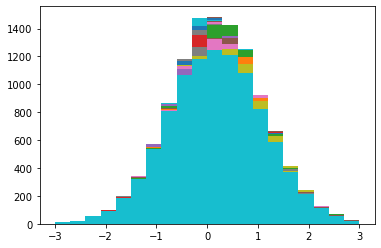

In [19]:
boot_hist_content = np.zeros( shape=(n_samples, hist_nbins))


simple_calc_mean = np.zeros( n_samples )
simple_calc_cov  = np.zeros( n_samples )


for bi in range(n_samples) :
    
    #boot_hist_content.append()
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)
    
    if not exists(fname) :  
        print('\n\n *** Missing %s' % fname )
        continue
        
    with open(fname,'rb') as f :
            
        final_push_weights_scaled = np.load(f)
        print(' boot %3d weights: ' % bi, end='')
        print( final_push_weights_scaled)
    
        hist_content,_,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=final_push_weights_scaled, range=[hist_xlow, hist_xhigh] )
        #print(hist_content)
        boot_hist_content[bi,:] = hist_content
        
        
        mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )
        
        simple_calc_mean[bi] = mean_cov['mean_x1']
        simple_calc_cov[bi]  = mean_cov['cov_x1x2']
    

In [20]:
hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        hist_corr_mat[bi,bj] = ccm[0,1]
        
        hist_cov_mat[bi,bj] = cvm[0,1]
        

In [21]:
hist_corr_mat[0,hist_nbins-1] = -1.

<function matplotlib.pyplot.show(close=None, block=None)>

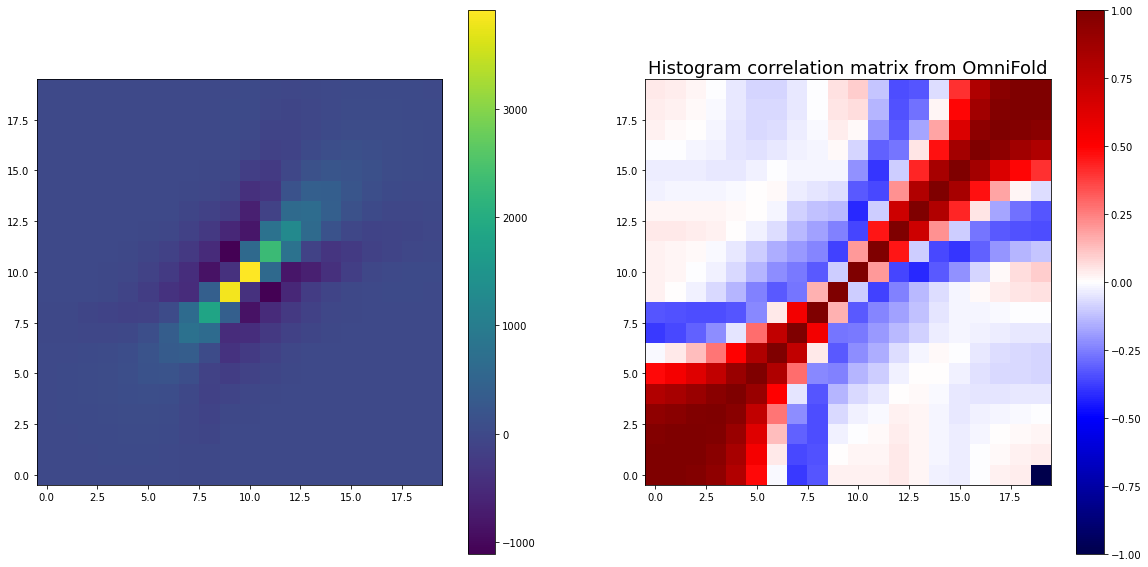

In [22]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [23]:
for bi in range(hist_nbins) :
    for bj in range(hist_nbins ) :
        
        calc_corr = hist_cov_mat[bi,bj] / np.sqrt( hist_cov_mat[bi,bi] * hist_cov_mat[bj,bj])
        
        print('  %2d, %2d :  histi  %10.2f   histj %10.2f  cov = %9.3f   cor = %9.4f  (%9.4f)' % 
              (bi, bj, boot_hist_content[0,bi], boot_hist_content[0,bj],
               hist_cov_mat[bi,bj], hist_corr_mat[bi,bj], calc_corr))



   0,  0 :  histi        8.12   histj       8.12  cov =     0.897   cor =    1.0000  (   1.0000)
   0,  1 :  histi        8.12   histj      18.19  cov =     1.736   cor =    0.9970  (   0.9970)
   0,  2 :  histi        8.12   histj      47.16  cov =     3.707   cor =    0.9822  (   0.9822)
   0,  3 :  histi        8.12   histj      89.89  cov =     5.415   cor =    0.9359  (   0.9359)
   0,  4 :  histi        8.12   histj     178.17  cov =     7.065   cor =    0.8011  (   0.8011)
   0,  5 :  histi        8.12   histj     303.76  cov =     5.650   cor =    0.4809  (   0.4809)
   0,  6 :  histi        8.12   histj     495.91  cov =    -0.208   cor =   -0.0121  (  -0.0121)
   0,  7 :  histi        8.12   histj     732.95  cov =   -10.201   cor =   -0.3888  (  -0.3888)
   0,  8 :  histi        8.12   histj     970.21  cov =   -13.461   cor =   -0.3333  (  -0.3333)
   0,  9 :  histi        8.12   histj    1134.90  cov =     1.453   cor =    0.0248  (   0.0248)
   0, 10 :  histi        8.12 

In [24]:
print('      ', end='')
for bj in range( hist_nbins ) :
    print('   %2d   ' % bj, end='')
print()

for bi in range( hist_nbins ) :
    print(' %2d : ' % bi, end='')
    for bj in range( hist_nbins ) :
        print( ' %6.3f ' % hist_corr_mat[bi,bj], end='')
    print()

          0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19   
  0 :   1.000   0.997   0.982   0.936   0.801   0.481  -0.012  -0.389  -0.333   0.025   0.030   0.030   0.042   0.017  -0.026  -0.034  -0.001   0.025   0.038  -1.000 
  1 :   0.997   1.000   0.994   0.960   0.842   0.539   0.045  -0.358  -0.339   0.005   0.018   0.021   0.040   0.019  -0.023  -0.035  -0.007   0.015   0.027   0.034 
  2 :   0.982   0.994   1.000   0.985   0.895   0.622   0.132  -0.309  -0.345  -0.025  -0.000   0.009   0.036   0.020  -0.020  -0.037  -0.017   0.001   0.012   0.017 
  3 :   0.936   0.960   0.985   1.000   0.958   0.740   0.269  -0.223  -0.347  -0.071  -0.028  -0.010   0.027   0.018  -0.017  -0.039  -0.031  -0.018  -0.011  -0.007 
  4 :   0.801   0.842   0.895   0.958   1.000   0.897   0.497  -0.049  -0.328  -0.145  -0.073  -0.043   0.007   0.012  -0.011  -0.039  -0.049  -0.047  -0.045  -0.044

In [25]:
cov_det = np.linalg.det( hist_cov_mat )
print('\n\n Histogram covariance matrix determinant:  %9.4f\n\n' % cov_det)



 Histogram covariance matrix determinant:  99522361709139.6719




In [26]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
print(hist_cov_inv)

[[ 9.83836854e+03 -1.11419899e+04  3.77650508e+03 -7.16970224e+02
   6.72021547e+01 -1.48653508e+01  4.65013519e+00 -7.66099703e-01
   2.57229635e-01 -6.15297311e-02  4.12995820e-02  3.37530435e-02
  -4.59691556e-01  1.34434176e+00 -2.72326570e+00  6.20549440e+00
  -6.56580522e-01 -6.13419324e+01  1.76706439e+02 -1.76953555e+02]
 [-1.11419899e+04  1.37282619e+04 -5.30343425e+03  1.25048354e+03
  -1.54001702e+02  2.74554814e+01 -7.05702926e+00  1.53184370e+00
  -4.35483581e-01  9.93576842e-02 -3.81753677e-02 -7.05776759e-02
   5.30745040e-01 -1.63896950e+00  3.92687910e+00 -8.94361143e+00
   2.33411061e+00  7.60671221e+01 -2.23082562e+02  2.23875314e+02]
 [ 3.77650508e+03 -5.30343425e+03  2.45775577e+03 -7.51358030e+02
   1.25603108e+02 -2.11120395e+01  4.23036488e+00 -1.00828369e+00
   2.47862537e-01 -6.62413520e-02 -5.08028273e-04  3.51499831e-02
  -1.88302213e-01  6.95771076e-01 -2.12287063e+00  4.87706118e+00
  -3.10249481e+00 -2.75952721e+01  8.69332090e+01 -8.84592775e+01]
 [-7.16

In [27]:
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )
print( cov_inv_test)

[[ 1.00000000e+00 -3.11220246e-12 -3.94719537e-13  2.32134325e-13
  -1.23180816e-14  1.77418756e-14 -1.84814456e-15 -3.33999386e-16
   2.06261893e-16  1.47317988e-17  3.81280898e-18 -1.05492575e-16
  -1.67495906e-16 -1.23863071e-16  8.24175850e-15  1.32603567e-14
   5.11959521e-15 -2.86872701e-13  8.96243316e-13 -1.28417719e-12]
 [ 3.90927912e-12  1.00000000e+00  6.86675430e-13  4.48290824e-13
   1.18079489e-15  3.15949346e-14 -5.57611763e-16 -8.91911280e-16
   4.36581818e-16  1.06267458e-16  8.98597775e-18 -1.14054903e-16
   5.56064137e-17 -2.54203022e-15  2.30271645e-14 -3.28438131e-14
   1.48477270e-13 -7.50186648e-13  1.76213720e-12 -2.12891649e-12]
 [ 1.24849622e-11 -2.12401376e-11  1.00000000e+00 -4.65846632e-14
  -5.29900750e-14  5.90244621e-14  9.50515058e-16 -3.37545120e-15
   1.22566880e-15 -9.99612634e-18 -2.41640120e-17 -1.17855870e-16
  -1.33154329e-15  2.46348641e-15  1.90347977e-15  3.54940810e-14
  -9.12879686e-14 -1.88875546e-13  1.57747453e-12 -1.76901118e-12]
 [ 2.47

<function matplotlib.pyplot.show(close=None, block=None)>

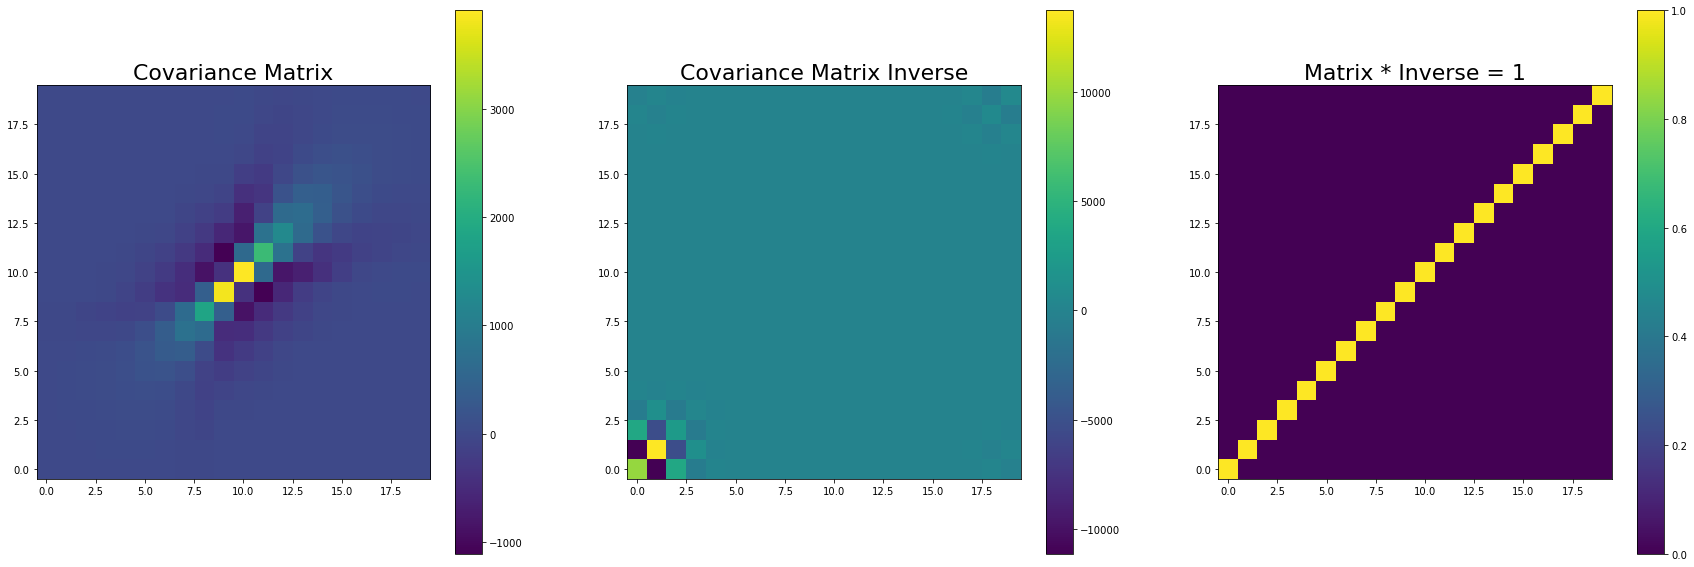

In [28]:
fig,ax = plt.subplots( 1, 3, figsize=(3*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im_covinv = ax[1].imshow(hist_cov_inv, origin='lower')
ax[1].figure.colorbar( im_covinv, ax=ax[1] )

im_covtest = ax[2].imshow(cov_inv_test, origin='lower')
ax[2].figure.colorbar( im_covtest, ax=ax[2] )

ax[0].set_title('Covariance Matrix', fontsize='22')
ax[1].set_title('Covariance Matrix Inverse', fontsize='22')
ax[2].set_title('Matrix * Inverse = 1', fontsize='22')

plt.show



(-50.0, 50.0)

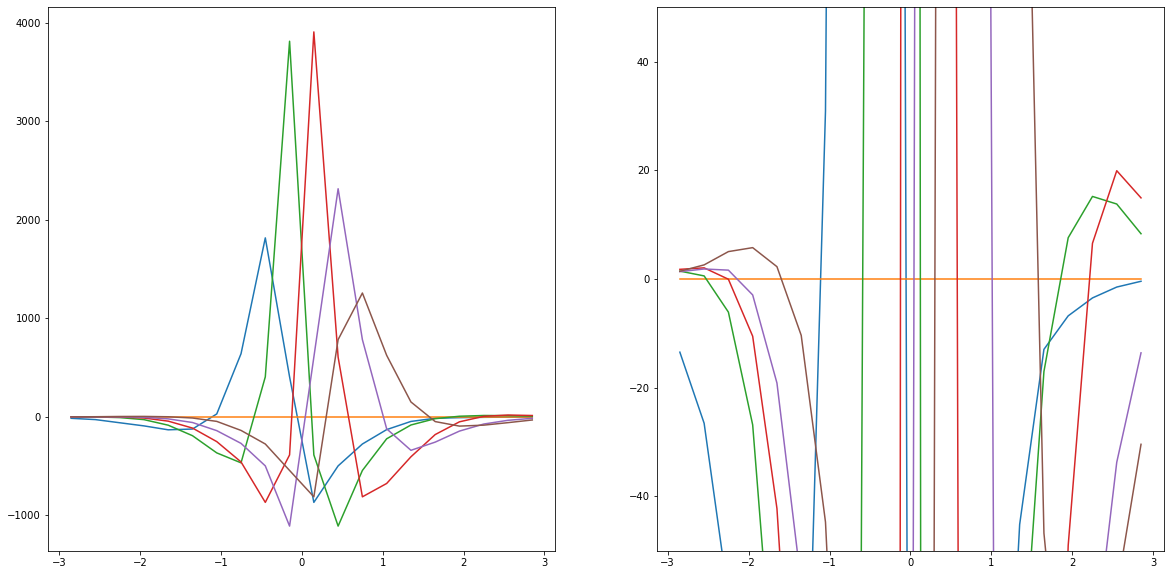

In [29]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[9,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[10,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[11,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[12,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[9,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[10,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[11,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[12,:] )


ax[1].set_ylim([-50,50])

(-50.0, 50.0)

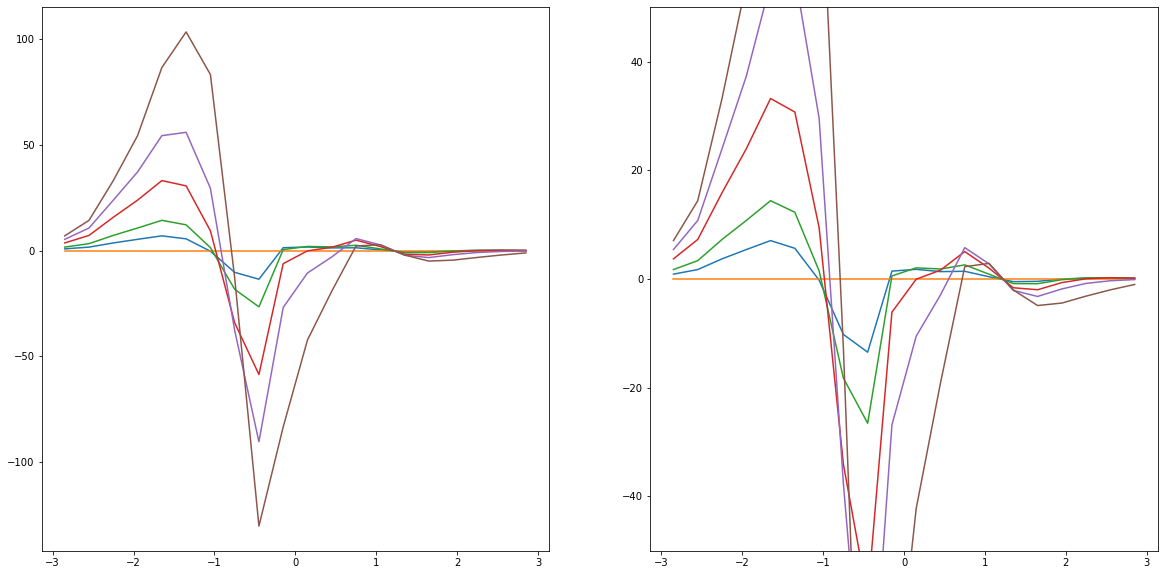

In [30]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[4,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[4,:] )


ax[1].set_ylim([-50,50])

## Try using the pseudo inverse of the covariance matrix for the chi2

In [31]:

#--- off
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat )


#--- not enough?
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.0001 )

#--- ok
hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.001 )
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.01 )

#-- probably too much
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.05 )


print(hist_cov_pinv)

[[ 3.65853186e-04  6.78877573e-04  1.34465155e-03  1.67709326e-03
   1.39254703e-03 -4.92915337e-04 -2.17536310e-03  1.64602588e-03
  -3.49771261e-04  6.05284304e-05 -1.17357753e-05  3.90118317e-05
  -9.04960304e-06 -4.87146775e-05  1.68697318e-04  2.41249645e-05
  -5.33619798e-05 -6.82798911e-05 -4.69527877e-05 -2.26651682e-05]
 [ 6.78877573e-04  1.26002238e-03  2.49681768e-03  3.11713498e-03
   2.59745838e-03 -8.91540481e-04 -4.01837663e-03  3.03402693e-03
  -6.37105428e-04  1.12766857e-04 -1.82973494e-05  7.14800255e-05
  -4.98530968e-06 -1.11593945e-04  3.27914045e-04  5.93248069e-05
  -1.03030702e-04 -1.38348701e-04 -9.76964026e-05 -4.82537215e-05]
 [ 1.34465155e-03  2.49681768e-03  4.95165122e-03  6.19300155e-03
   5.19430143e-03 -1.68123975e-03 -7.89347145e-03  5.93444993e-03
  -1.21798759e-03  2.24753994e-04 -2.32371576e-05  1.36582298e-04
   3.94653017e-05 -3.09937917e-04  7.08435994e-04  1.77340668e-04
  -2.18836456e-04 -3.19993640e-04 -2.35525372e-04 -1.20265407e-04]
 [ 1.67

In [32]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv

In [33]:
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

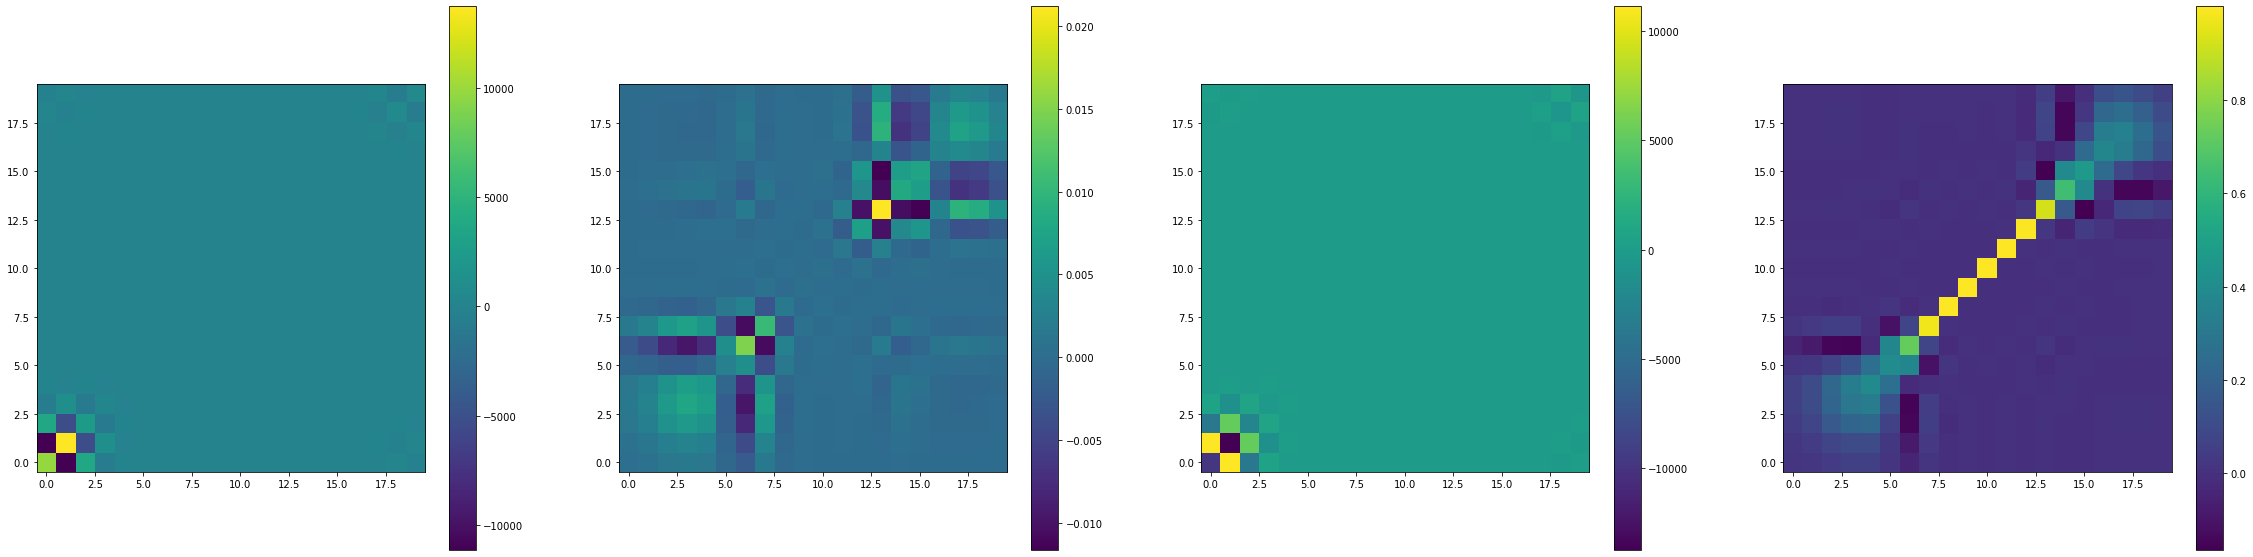

In [34]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [35]:
for bi in range( hist_nbins ) :
    for bj in range( hist_nbins ) :
        print('  %3d, %3d:   inv = %8.3f   pinv = %8.3f' % (bi, bj, hist_cov_inv[bi,bj], hist_cov_pinv[bi,bj]))

    0,   0:   inv = 9838.369   pinv =    0.000
    0,   1:   inv = -11141.990   pinv =    0.001
    0,   2:   inv = 3776.505   pinv =    0.001
    0,   3:   inv = -716.970   pinv =    0.002
    0,   4:   inv =   67.202   pinv =    0.001
    0,   5:   inv =  -14.865   pinv =   -0.000
    0,   6:   inv =    4.650   pinv =   -0.002
    0,   7:   inv =   -0.766   pinv =    0.002
    0,   8:   inv =    0.257   pinv =   -0.000
    0,   9:   inv =   -0.062   pinv =    0.000
    0,  10:   inv =    0.041   pinv =   -0.000
    0,  11:   inv =    0.034   pinv =    0.000
    0,  12:   inv =   -0.460   pinv =   -0.000
    0,  13:   inv =    1.344   pinv =   -0.000
    0,  14:   inv =   -2.723   pinv =    0.000
    0,  15:   inv =    6.205   pinv =    0.000
    0,  16:   inv =   -0.657   pinv =   -0.000
    0,  17:   inv =  -61.342   pinv =   -0.000
    0,  18:   inv =  176.706   pinv =   -0.000
    0,  19:   inv = -176.954   pinv =   -0.000
    1,   0:   inv = -11141.990   pinv =    0.001
    1,   

In [36]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [37]:
hist_cov_mat_diagonal

array([[8.97378611e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.37661425e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.58681484e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000

In [38]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )
print(hist_cov_inv_diagonal)

[[1.11435685e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.96154647e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.30193248e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.68084310e-02
  0.0

In [39]:
model_mu = 0.2
model_sigma = 0.90
model_cov = model_sigma * model_sigma

hist_sum = np.sum( unfolded_hist )

model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt(  2 * 3.14159265 ) )

model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )




<function matplotlib.pyplot.show(close=None, block=None)>

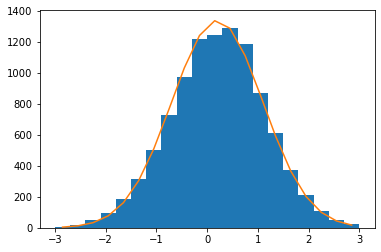

In [40]:

plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )
plt.plot( hist_bin_centers, model_pred )



plt.show

In [41]:
weight_sum

10096.306320154466

In [42]:
np.sum(unfolded_hist)

10078.190614594108

In [43]:
for bi in range( hist_nbins ) :
    diff = unfolded_hist[bi] - model_pred[bi]
    print(' %3d : x = %5.2f  model = %8.1f  hist = %8.1f  diff = %8.1f   sqrt(covii) = %8.1f' % 
          (bi, hist_bin_centers[bi], model_pred[bi], unfolded_hist[bi], diff, np.sqrt(hist_cov_mat[bi,bi]) ))

   0 : x = -2.85  model =      4.3  hist =      8.1  diff =      3.8   sqrt(covii) =      0.9
   1 : x = -2.55  model =     12.6  hist =     18.4  diff =      5.8   sqrt(covii) =      1.8
   2 : x = -2.25  model =     33.0  hist =     48.3  diff =     15.3   sqrt(covii) =      4.0
   3 : x = -1.95  model =     77.3  hist =     93.0  diff =     15.8   sqrt(covii) =      6.1
   4 : x = -1.65  model =    162.1  hist =    185.4  diff =     23.3   sqrt(covii) =      9.3
   5 : x = -1.35  model =    304.2  hist =    314.6  diff =     10.5   sqrt(covii) =     12.4
   6 : x = -1.05  model =    510.8  hist =    504.3  diff =     -6.5   sqrt(covii) =     18.0
   7 : x = -0.75  model =    767.8  hist =    729.5  diff =    -38.3   sqrt(covii) =     27.7
   8 : x = -0.45  model =   1032.5  hist =    976.7  diff =    -55.8   sqrt(covii) =     42.6
   9 : x = -0.15  model =   1242.6  hist =   1222.2  diff =    -20.4   sqrt(covii) =     61.8
  10 : x =  0.15  model =   1338.1  hist =   1246.3  diff = 

In [44]:
dy = unfolded_hist - model_pred
    
cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)

cov_pinv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
dy_times_cov_pinv_times_dy =  np.sum( dy.T * cov_pinv_times_dy, axis=0)
    
this_chi2 = dy_times_cov_inv_times_dy

this_chi2_pinv = dy_times_cov_pinv_times_dy

print('\n\n chi2 = %10.3f, with pseudoinverse = %10.3f\n\n' % (this_chi2, this_chi2_pinv) )



 chi2 =  62946.417, with pseudoinverse =     35.233




In [45]:
dy

array([  3.83511103,   5.84828027,  15.33278927,  15.76907439,
        23.33891075,  10.46618119,  -6.50708665, -38.28521335,
       -55.82912321, -20.38568398, -91.84410049,   2.68801217,
        74.34889262,  12.23583423,  17.60206937,   9.00957735,
        10.04733646,   9.85551666,   9.0060591 ,   4.19671018])

In [46]:
cov_inv_times_dy

array([ 2.07911575e+04, -2.76239909e+04,  1.21222197e+04, -3.60023372e+03,
        6.41921280e+02, -1.27052121e+02,  2.71979994e+01, -5.67870604e+00,
        1.31220240e+00, -3.44250941e-01,  3.45570693e-02, -1.36796624e-02,
       -1.14674281e-01,  7.86520463e-01, -4.38787047e+00,  5.06500441e+00,
        8.67524159e+01, -5.69452841e+02,  1.36867862e+03, -1.31304587e+03])

<function matplotlib.pyplot.show(close=None, block=None)>

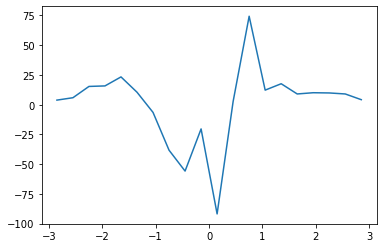

In [47]:
plt.plot( hist_bin_centers, dy )
plt.show

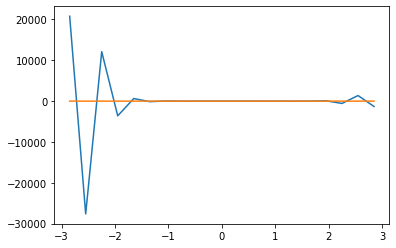

In [48]:
plt.plot( hist_bin_centers, cov_inv_times_dy )
plt.plot( hist_bin_centers, cov_pinv_times_dy )

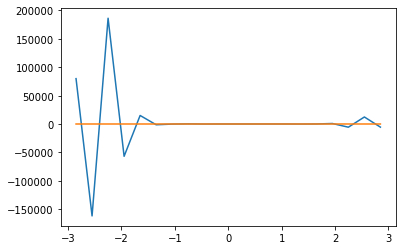

In [49]:
plt.plot( hist_bin_centers, dy.T * cov_inv_times_dy )
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )

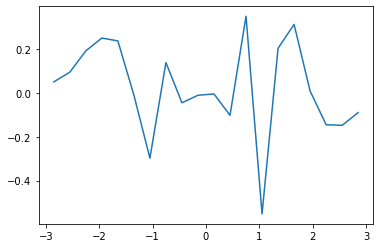

In [50]:
plt.plot( hist_bin_centers, cov_pinv_times_dy )

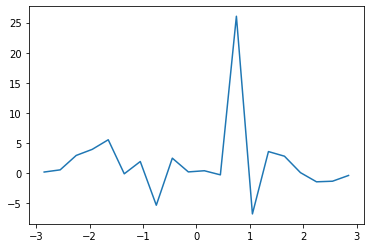

In [51]:
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )

In [52]:
n_scan_points = 10

scan_min = 0.0
scan_max = 0.4

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = scan_par_vals[si]
    model_sigma = 0.9
    model_cov = model_sigma * model_sigma

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.000  chi2 =          283.67,   diagonal chi2 =          838.45
 scan point   1  par   0.044  chi2 =          187.63,   diagonal chi2 =          525.45
 scan point   2  par   0.089  chi2 =          115.36,   diagonal chi2 =          298.82
 scan point   3  par   0.133  chi2 =           66.25,   diagonal chi2 =          152.70
 scan point   4  par   0.178  chi2 =           39.91,   diagonal chi2 =           83.16
 scan point   5  par   0.222  chi2 =           36.23,   diagonal chi2 =           88.07
 scan point   6  par   0.267  chi2 =           55.33,   diagonal chi2 =          167.00
 scan point   7  par   0.311  chi2 =           97.57,   diagonal chi2 =          321.14
 scan point   8  par   0.356  chi2 =          163.53,   diagonal chi2 =          553.25
 scan point   9  par   0.400  chi2 =          254.02,   diagonal chi2 =          867.64


<function matplotlib.pyplot.show(close=None, block=None)>

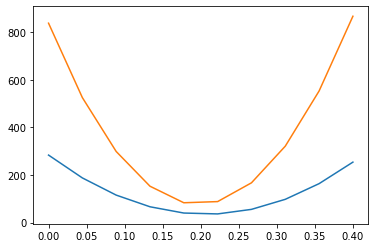

In [53]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [54]:
n_scan_points = 10

scan_min = 0.7
scan_max = 0.9

#scan_min = 0.78
#scan_max = 0.84

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )


for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = 0.2
    model_sigma = np.sqrt( scan_par_vals[si] )
    model_cov = scan_par_vals[si]

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )

    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy
    
    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
     
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.700  chi2 =          107.88,   diagonal chi2 =          397.69
 scan point   1  par   0.722  chi2 =           86.90,   diagonal chi2 =          309.74
 scan point   2  par   0.744  chi2 =           69.18,   diagonal chi2 =          233.29
 scan point   3  par   0.767  chi2 =           54.65,   diagonal chi2 =          168.49
 scan point   4  par   0.789  chi2 =           43.23,   diagonal chi2 =          115.52
 scan point   5  par   0.811  chi2 =           34.89,   diagonal chi2 =           74.62
 scan point   6  par   0.833  chi2 =           29.56,   diagonal chi2 =           46.01
 scan point   7  par   0.856  chi2 =           27.20,   diagonal chi2 =           29.96
 scan point   8  par   0.878  chi2 =           27.75,   diagonal chi2 =           26.73
 scan point   9  par   0.900  chi2 =           31.17,   diagonal chi2 =           36.61


<function matplotlib.pyplot.show(close=None, block=None)>

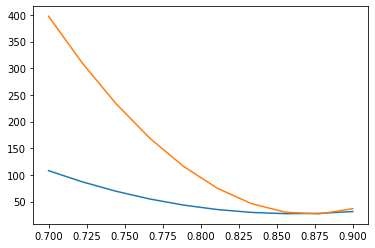

In [55]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [56]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

xMin = hist_xlow
xMax = hist_xhigh

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [57]:


def f(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta*model_pred

class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType):
        self.setData(xHist, bin_edges, covMatInv)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binSize = bin_edges[1] - bin_edges[0]
        self.data = xHist, bin_edges, numVal, numBins, binSize, covMatInv

    def chi2LS(self, par):           # least squares
        xHist, bin_edges, numVal, numBins, binSize, covMatInv = self.data
        xMid = bin_edges[:numBins] + 0.5*binSize
        binProb = f(xMid, par)*binSize
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def __call__(self, par):
        if fitType == 'full cov' :
            return self.chi2LS(par)
        elif fitType == 'diagonal cov' :
            return self.chi2DiagonalOnly(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1
        
        

In [58]:
# Initialize Minuit and set up fit:
theta = 1
mu = 0.2
sigma2 = 0.81
fitType = 'full cov'

parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
parname = ['theta', 'mu', 'sigma2']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
parfix  = [False, False, False]            # change to fix/free param.
parlim  = [(0.5, 1.5), (None, None), (0., None)]

chisq = ChiSquared(unfolded_hist, hist_bin_edges, hist_cov_pinv, fitType)
chisq_diag = ChiSquared(unfolded_hist, hist_bin_edges, hist_cov_inv_diagonal, fitType)


m = Minuit(chisq, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 1.0                      # errors from chi2 = chi2min + 1


m_diag = Minuit(chisq_diag, parin, name=parname)
m_diag.errors = parstep
m_diag.fixed = parfix
m_diag.limits = parlim
m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1

In [59]:
# do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
parhat = m.values                                 # max-likelihood estimates
sigma_parhat = m.errors                           # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

m_diag.migrad()                                        # minimize -logL
parhat_diag = m_diag.values                                 # max-likelihood estimates
sigma_parhat_diag = m_diag.errors                           # standard deviations
cov_diag = m_diag.covariance                                # covariance matrix
rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.




In [60]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:

        print(' %2d %-10s  =  %7.4f +/- %7.4f ,   diagonal cov result = %7.4f +/- %7.4f' %
              (i, m.parameters[i], parhat[i], sigma_parhat[i],
              parhat_diag[i], sigma_parhat_diag[i])
             )
            
            
            
print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not m.fixed[i]:
        for j in range(m.npar):
            if not m.fixed[j]:
                print(i, j, "{:9.6f}".format(cov[i,j]), "{:9.6f}".format(rho[i,j]))

# Retrieve minimized chi-squared, etc.
ndof = hist_nbins - m.nfit - 1           # for fixed numVal
chi2min = chisq(parhat)
print ("chi2min = ", chi2min, ",     ndof = ", ndof)
pval = chi2.sf(chi2min, ndof)
print ("pval = ", pval)

par index, name, estimate, standard deviation:
  0 theta       =   0.9987 +/-  0.0072 ,   diagonal cov result =  0.9989 +/-  0.0111
  1 mu          =   0.2042 +/-  0.0130 ,   diagonal cov result =  0.1977 +/-  0.0069
  2 sigma2      =   0.8619 +/-  0.0185 ,   diagonal cov result =  0.8725 +/-  0.0096

free par indices, covariance, correlation coeff.:
0 0  0.000052  1.000000
0 1  0.000004  0.040870
0 2  0.000005  0.038218
1 0  0.000004  0.040870
1 1  0.000168  1.000000
1 2 -0.000017 -0.069081
2 0  0.000005  0.038218
2 1 -0.000017 -0.069081
2 2  0.000344  1.000000
chi2min =  26.917279676829946 ,     ndof =  16
pval =  0.0424117756041264


In [61]:
n_scan_points = 40

scan_min = parhat[1] - 2*sigma_parhat[1]
scan_max = parhat[1] + 2*sigma_parhat[1]

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = scan_par_vals[si]
    model_sigma = 0.9
    model_cov = model_sigma * model_sigma

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.178  chi2 =           39.76,   diagonal chi2 =           82.86
 scan point   1  par   0.180  chi2 =           39.33,   diagonal chi2 =           81.95
 scan point   2  par   0.181  chi2 =           38.92,   diagonal chi2 =           81.11
 scan point   3  par   0.182  chi2 =           38.53,   diagonal chi2 =           80.33
 scan point   4  par   0.184  chi2 =           38.15,   diagonal chi2 =           79.63
 scan point   5  par   0.185  chi2 =           37.80,   diagonal chi2 =           78.99
 scan point   6  par   0.186  chi2 =           37.47,   diagonal chi2 =           78.41
 scan point   7  par   0.188  chi2 =           37.16,   diagonal chi2 =           77.90
 scan point   8  par   0.189  chi2 =           36.87,   diagonal chi2 =           77.46
 scan point   9  par   0.190  chi2 =           36.60,   diagonal chi2 =           77.09
 scan point  10  par   0.192  chi2 =           36.35,   diagonal chi2 =           76.78
 scan point  11  par   0.193  ch

<function matplotlib.pyplot.show(close=None, block=None)>

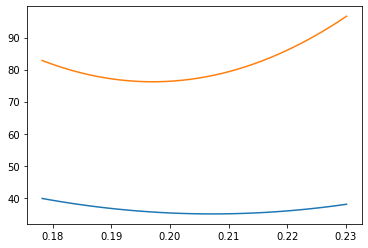

In [62]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [63]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals[si] < min_chi2 :
        min_chi2 = scan_chi2_vals[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals[si] - scan_chi2_vals[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals[si], dx, dchi2)
         )


  point for min chi2 :   22  val =  34.935
   0 :  x =   0.1782  chi2 =      39.76   dx = -0.0293  dchi2 =  4.8292
   1 :  x =   0.1795  chi2 =      39.33   dx = -0.0280  dchi2 =  4.3963
   2 :  x =   0.1809  chi2 =      38.92   dx = -0.0266  dchi2 =  3.9837
   3 :  x =   0.1822  chi2 =      38.53   dx = -0.0253  dchi2 =  3.5914
   4 :  x =   0.1835  chi2 =      38.15   dx = -0.0240  dchi2 =  3.2194
   5 :  x =   0.1849  chi2 =      37.80   dx = -0.0226  dchi2 =  2.8677
   6 :  x =   0.1862  chi2 =      37.47   dx = -0.0213  dchi2 =  2.5364
   7 :  x =   0.1875  chi2 =      37.16   dx = -0.0200  dchi2 =  2.2254
   8 :  x =   0.1889  chi2 =      36.87   dx = -0.0186  dchi2 =  1.9347
   9 :  x =   0.1902  chi2 =      36.60   dx = -0.0173  dchi2 =  1.6643
  10 :  x =   0.1915  chi2 =      36.35   dx = -0.0160  dchi2 =  1.4143
  11 :  x =   0.1928  chi2 =      36.12   dx = -0.0146  dchi2 =  1.1845
  12 :  x =   0.1942  chi2 =      35.91   dx = -0.0133  dchi2 =  0.9751
  13 :  x =   0.1955 

In [64]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals_diagonal[si] < min_chi2 :
        min_chi2 = scan_chi2_vals_diagonal[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals_diagonal[si] - scan_chi2_vals_diagonal[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals_diagonal[si], dx, dchi2)
         )


  point for min chi2 :   14  val =  76.210
   0 :  x =   0.1782  chi2 =      82.86   dx = -0.0186  dchi2 =  6.6456
   1 :  x =   0.1795  chi2 =      81.95   dx = -0.0173  dchi2 =  5.7385
   2 :  x =   0.1809  chi2 =      81.11   dx = -0.0160  dchi2 =  4.8981
   3 :  x =   0.1822  chi2 =      80.33   dx = -0.0146  dchi2 =  4.1242
   4 :  x =   0.1835  chi2 =      79.63   dx = -0.0133  dchi2 =  3.4169
   5 :  x =   0.1849  chi2 =      78.99   dx = -0.0120  dchi2 =  2.7762
   6 :  x =   0.1862  chi2 =      78.41   dx = -0.0107  dchi2 =  2.2019
   7 :  x =   0.1875  chi2 =      77.90   dx = -0.0093  dchi2 =  1.6942
   8 :  x =   0.1889  chi2 =      77.46   dx = -0.0080  dchi2 =  1.2530
   9 :  x =   0.1902  chi2 =      77.09   dx = -0.0067  dchi2 =  0.8781
  10 :  x =   0.1915  chi2 =      76.78   dx = -0.0053  dchi2 =  0.5697
  11 :  x =   0.1928  chi2 =      76.54   dx = -0.0040  dchi2 =  0.3277
  12 :  x =   0.1942  chi2 =      76.36   dx = -0.0027  dchi2 =  0.1521
  13 :  x =   0.1955 

In [65]:
n_scan_points = 40

scan_min = parhat[2] - 2*sigma_parhat[2]
scan_max = parhat[2] + 2*sigma_parhat[2]

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = 0.2
    model_cov = scan_par_vals[si]
    model_sigma = np.sqrt(model_cov)

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.825  chi2 =           31.24,   diagonal chi2 =           55.48
 scan point   1  par   0.827  chi2 =           30.83,   diagonal chi2 =           53.20
 scan point   2  par   0.829  chi2 =           30.44,   diagonal chi2 =           51.01
 scan point   3  par   0.831  chi2 =           30.06,   diagonal chi2 =           48.92
 scan point   4  par   0.832  chi2 =           29.72,   diagonal chi2 =           46.92
 scan point   5  par   0.834  chi2 =           29.39,   diagonal chi2 =           45.00
 scan point   6  par   0.836  chi2 =           29.08,   diagonal chi2 =           43.18
 scan point   7  par   0.838  chi2 =           28.80,   diagonal chi2 =           41.46
 scan point   8  par   0.840  chi2 =           28.53,   diagonal chi2 =           39.82
 scan point   9  par   0.842  chi2 =           28.29,   diagonal chi2 =           38.28
 scan point  10  par   0.844  chi2 =           28.07,   diagonal chi2 =           36.83
 scan point  11  par   0.846  ch

<function matplotlib.pyplot.show(close=None, block=None)>

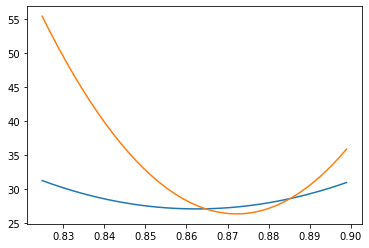

In [66]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [67]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals[si] < min_chi2 :
        min_chi2 = scan_chi2_vals[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals[si] - scan_chi2_vals[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals[si], dx, dchi2)
         )

  point for min chi2 :   20  val =  27.059
   0 :  x =   0.8248  chi2 =      31.24   dx = -0.0380  dchi2 =  4.1843
   1 :  x =   0.8267  chi2 =      30.83   dx = -0.0361  dchi2 =  3.7695
   2 :  x =   0.8286  chi2 =      30.44   dx = -0.0342  dchi2 =  3.3766
   3 :  x =   0.8305  chi2 =      30.06   dx = -0.0323  dchi2 =  3.0054
   4 :  x =   0.8324  chi2 =      29.72   dx = -0.0304  dchi2 =  2.6560
   5 :  x =   0.8343  chi2 =      29.39   dx = -0.0285  dchi2 =  2.3284
   6 :  x =   0.8362  chi2 =      29.08   dx = -0.0266  dchi2 =  2.0224
   7 :  x =   0.8381  chi2 =      28.80   dx = -0.0247  dchi2 =  1.7381
   8 :  x =   0.8400  chi2 =      28.53   dx = -0.0228  dchi2 =  1.4755
   9 :  x =   0.8419  chi2 =      28.29   dx = -0.0209  dchi2 =  1.2344
  10 :  x =   0.8439  chi2 =      28.07   dx = -0.0190  dchi2 =  1.0150
  11 :  x =   0.8458  chi2 =      27.88   dx = -0.0171  dchi2 =  0.8170
  12 :  x =   0.8477  chi2 =      27.70   dx = -0.0152  dchi2 =  0.6406
  13 :  x =   0.8496 

In [68]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals_diagonal[si] < min_chi2 :
        min_chi2 = scan_chi2_vals_diagonal[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals_diagonal[si] - scan_chi2_vals_diagonal[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals_diagonal[si], dx, dchi2)
         )


  point for min chi2 :   25  val =  26.320
   0 :  x =   0.8248  chi2 =      55.48   dx = -0.0475  dchi2 = 29.1590
   1 :  x =   0.8267  chi2 =      53.20   dx = -0.0456  dchi2 = 26.8810
   2 :  x =   0.8286  chi2 =      51.01   dx = -0.0437  dchi2 = 24.6944
   3 :  x =   0.8305  chi2 =      48.92   dx = -0.0418  dchi2 = 22.5993
   4 :  x =   0.8324  chi2 =      46.92   dx = -0.0399  dchi2 = 20.5958
   5 :  x =   0.8343  chi2 =      45.00   dx = -0.0380  dchi2 = 18.6842
   6 :  x =   0.8362  chi2 =      43.18   dx = -0.0361  dchi2 = 16.8646
   7 :  x =   0.8381  chi2 =      41.46   dx = -0.0342  dchi2 = 15.1372
   8 :  x =   0.8400  chi2 =      39.82   dx = -0.0323  dchi2 = 13.5022
   9 :  x =   0.8419  chi2 =      38.28   dx = -0.0304  dchi2 = 11.9596
  10 :  x =   0.8439  chi2 =      36.83   dx = -0.0285  dchi2 = 10.5097
  11 :  x =   0.8458  chi2 =      35.47   dx = -0.0266  dchi2 =  9.1527
  12 :  x =   0.8477  chi2 =      34.21   dx = -0.0247  dchi2 =  7.8887
  13 :  x =   0.8496 

In [69]:
boot_hist_content.shape

(1000, 20)

In [70]:
len(boot_hist_content)

1000

In [71]:

chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



for si in range( len(boot_hist_content) ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.2024 +/-   0.0132  (  0.2007 +/-   0.0071)    sig2   0.8667 +/-   0.0190  (  0.8861 +/-   0.0100)
   1 : mu   0.1972 +/-   0.0131  (  0.1999 +/-   0.0071)    sig2   0.8211 +/-   0.0186  (  0.8244 +/-   0.0096)
   2 : mu   0.1995 +/-   0.0129  (  0.2031 +/-   0.0072)    sig2   0.8007 +/-   0.0185  (  0.8053 +/-   0.0098)
   3 : mu   0.1809 +/-   0.0130  (  0.1874 +/-   0.0071)    sig2   0.8549 +/-   0.0186  (  0.8693 +/-   0.0099)
   4 : mu   0.2024 +/-   0.0131  (  0.2082 +/-   0.0072)    sig2   0.8359 +/-   0.0186  (  0.8447 +/-   0.0098)
   5 : mu   0.1717 +/-   0.0131  (  0.1726 +/-   0.0071)    sig2   0.8339 +/-   0.0187  (  0.8458 +/-   0.0098)
   6 : mu   0.2083 +/-   0.0131  (  0.2113 +/-   0.0072)    sig2   0.8246 +/-   0.0186  (  0.8307 +/-   0.0098)
   7 : mu   0.1896 +/-   0.0132  (  0.1902 +/-   0.0072)    sig2   0.8398 +/-   0.0189  (  0.8471 +/-   0.0099)
   8 : mu   0.1918 +/-   0.0133  (  0.2004 +/-   0.0072)    sig2   0.8534 +/-   0.0191  (  0.8633 +/-   

 108 : mu   0.1731 +/-   0.0131  (  0.1717 +/-   0.0071)    sig2   0.8310 +/-   0.0184  (  0.8381 +/-   0.0097)
 109 : mu   0.1877 +/-   0.0130  (  0.1931 +/-   0.0070)    sig2   0.8445 +/-   0.0183  (  0.8505 +/-   0.0095)
 110 : mu   0.1744 +/-   0.0132  (  0.1736 +/-   0.0071)    sig2   0.8539 +/-   0.0184  (  0.8632 +/-   0.0097)
 111 : mu   0.1922 +/-   0.0131  (  0.1902 +/-   0.0070)    sig2   0.8643 +/-   0.0185  (  0.8695 +/-   0.0096)
 112 : mu   0.2077 +/-   0.0131  (  0.2024 +/-   0.0071)    sig2   0.8444 +/-   0.0188  (  0.8709 +/-   0.0100)
 113 : mu   0.1876 +/-   0.0130  (  0.1942 +/-   0.0071)    sig2   0.8413 +/-   0.0184  (  0.8561 +/-   0.0097)
 114 : mu   0.2011 +/-   0.0131  (  0.1978 +/-   0.0069)    sig2   0.8821 +/-   0.0184  (  0.8813 +/-   0.0094)
 115 : mu   0.2017 +/-   0.0130  (  0.2012 +/-   0.0069)    sig2   0.8515 +/-   0.0185  (  0.8598 +/-   0.0096)
 116 : mu   0.2063 +/-   0.0131  (  0.2064 +/-   0.0070)    sig2   0.8564 +/-   0.0186  (  0.8635 +/-   

 316 : mu   0.1841 +/-   0.0131  (  0.1821 +/-   0.0072)    sig2   0.8130 +/-   0.0188  (  0.8267 +/-   0.0098)
 317 : mu   0.1710 +/-   0.0132  (  0.1633 +/-   0.0070)    sig2   0.8378 +/-   0.0188  (  0.8403 +/-   0.0096)
 318 : mu   0.2165 +/-   0.0130  (  0.2165 +/-   0.0070)    sig2   0.8404 +/-   0.0188  (  0.8500 +/-   0.0097)
 319 : mu   0.1964 +/-   0.0130  (  0.1970 +/-   0.0070)    sig2   0.8240 +/-   0.0175  (  0.8237 +/-   0.0093)
 320 : mu   0.1931 +/-   0.0130  (  0.2015 +/-   0.0070)    sig2   0.8677 +/-   0.0185  (  0.8766 +/-   0.0097)
 321 : mu   0.1816 +/-   0.0131  (  0.1879 +/-   0.0070)    sig2   0.8693 +/-   0.0190  (  0.8710 +/-   0.0097)
 322 : mu   0.1714 +/-   0.0131  (  0.1784 +/-   0.0071)    sig2   0.8482 +/-   0.0185  (  0.8436 +/-   0.0095)
 323 : mu   0.2138 +/-   0.0133  (  0.2144 +/-   0.0071)    sig2   0.8599 +/-   0.0188  (  0.8583 +/-   0.0097)
 324 : mu   0.1889 +/-   0.0131  (  0.1996 +/-   0.0070)    sig2   0.8917 +/-   0.0190  (  0.9049 +/-   

 506 : mu   0.2154 +/-   0.0132  (  0.2129 +/-   0.0071)    sig2   0.8498 +/-   0.0186  (  0.8714 +/-   0.0098)
 507 : mu   0.1959 +/-   0.0130  (  0.1977 +/-   0.0070)    sig2   0.8407 +/-   0.0184  (  0.8497 +/-   0.0096)
 508 : mu   0.2166 +/-   0.0129  (  0.2244 +/-   0.0073)    sig2   0.7943 +/-   0.0183  (  0.8103 +/-   0.0099)
 509 : mu   0.1939 +/-   0.0131  (  0.1987 +/-   0.0070)    sig2   0.8238 +/-   0.0180  (  0.8225 +/-   0.0094)
 510 : mu   0.1977 +/-   0.0130  (  0.2076 +/-   0.0071)    sig2   0.8417 +/-   0.0185  (  0.8524 +/-   0.0098)
 511 : mu   0.2004 +/-   0.0131  (  0.1977 +/-   0.0071)    sig2   0.8263 +/-   0.0187  (  0.8331 +/-   0.0097)
 512 : mu   0.1945 +/-   0.0132  (  0.1962 +/-   0.0070)    sig2   0.8727 +/-   0.0191  (  0.8745 +/-   0.0097)
 513 : mu   0.1984 +/-   0.0131  (  0.1991 +/-   0.0071)    sig2   0.8418 +/-   0.0185  (  0.8546 +/-   0.0098)
 514 : mu   0.2204 +/-   0.0130  (  0.2175 +/-   0.0070)    sig2   0.8419 +/-   0.0187  (  0.8444 +/-   

 597 : mu   0.1902 +/-   0.0130  (  0.1882 +/-   0.0069)    sig2   0.8529 +/-   0.0183  (  0.8600 +/-   0.0095)
 598 : mu   0.1902 +/-   0.0131  (  0.1951 +/-   0.0071)    sig2   0.8448 +/-   0.0184  (  0.8476 +/-   0.0096)
 599 : mu   0.2022 +/-   0.0131  (  0.1983 +/-   0.0069)    sig2   0.8738 +/-   0.0185  (  0.8825 +/-   0.0096)
 600 : mu   0.2132 +/-   0.0129  (  0.2161 +/-   0.0070)    sig2   0.8211 +/-   0.0178  (  0.8246 +/-   0.0093)
 601 : mu   0.2089 +/-   0.0129  (  0.2064 +/-   0.0069)    sig2   0.8422 +/-   0.0180  (  0.8463 +/-   0.0094)
 602 : mu   0.1817 +/-   0.0132  (  0.1925 +/-   0.0072)    sig2   0.8452 +/-   0.0187  (  0.8504 +/-   0.0098)
 603 : mu   0.1861 +/-   0.0130  (  0.1885 +/-   0.0071)    sig2   0.8355 +/-   0.0188  (  0.8414 +/-   0.0098)
 604 : mu   0.2112 +/-   0.0130  (  0.2215 +/-   0.0071)    sig2   0.8371 +/-   0.0185  (  0.8408 +/-   0.0096)
 605 : mu   0.1928 +/-   0.0131  (  0.1959 +/-   0.0071)    sig2   0.8534 +/-   0.0185  (  0.8556 +/-   

 714 : mu   0.1961 +/-   0.0130  (  0.1956 +/-   0.0070)    sig2   0.8443 +/-   0.0184  (  0.8412 +/-   0.0094)
 715 : mu   0.1981 +/-   0.0129  (  0.2046 +/-   0.0070)    sig2   0.8351 +/-   0.0183  (  0.8317 +/-   0.0094)
 716 : mu   0.1894 +/-   0.0129  (  0.1976 +/-   0.0070)    sig2   0.8336 +/-   0.0184  (  0.8295 +/-   0.0095)
 717 : mu   0.1723 +/-   0.0130  (  0.1797 +/-   0.0072)    sig2   0.8170 +/-   0.0187  (  0.8249 +/-   0.0099)
 718 : mu   0.1818 +/-   0.0130  (  0.1818 +/-   0.0069)    sig2   0.8497 +/-   0.0180  (  0.8503 +/-   0.0094)
 719 : mu   0.2188 +/-   0.0129  (  0.2231 +/-   0.0069)    sig2   0.8452 +/-   0.0183  (  0.8457 +/-   0.0094)
 720 : mu   0.1801 +/-   0.0131  (  0.1801 +/-   0.0071)    sig2   0.8300 +/-   0.0182  (  0.8345 +/-   0.0097)
 721 : mu   0.2032 +/-   0.0130  (  0.1949 +/-   0.0070)    sig2   0.8430 +/-   0.0187  (  0.8566 +/-   0.0098)
 722 : mu   0.2028 +/-   0.0131  (  0.2104 +/-   0.0070)    sig2   0.8736 +/-   0.0185  (  0.8858 +/-   

 788 : mu   0.2068 +/-   0.0132  (  0.2104 +/-   0.0072)    sig2   0.8420 +/-   0.0193  (  0.8484 +/-   0.0100)
 789 : mu   0.2065 +/-   0.0129  (  0.2131 +/-   0.0070)    sig2   0.8422 +/-   0.0183  (  0.8627 +/-   0.0098)
 790 : mu   0.1770 +/-   0.0130  (  0.1903 +/-   0.0073)    sig2   0.8144 +/-   0.0188  (  0.8241 +/-   0.0101)
 791 : mu   0.2064 +/-   0.0129  (  0.2150 +/-   0.0069)    sig2   0.8821 +/-   0.0188  (  0.8840 +/-   0.0097)
 792 : mu   0.1950 +/-   0.0129  (  0.1860 +/-   0.0069)    sig2   0.8368 +/-   0.0186  (  0.8443 +/-   0.0096)
 793 : mu   0.1984 +/-   0.0130  (  0.2006 +/-   0.0072)    sig2   0.8093 +/-   0.0185  (  0.8159 +/-   0.0098)
 794 : mu   0.2131 +/-   0.0131  (  0.2078 +/-   0.0069)    sig2   0.8778 +/-   0.0188  (  0.8894 +/-   0.0097)
 795 : mu   0.2024 +/-   0.0131  (  0.2111 +/-   0.0071)    sig2   0.8595 +/-   0.0186  (  0.8731 +/-   0.0098)
 796 : mu   0.2160 +/-   0.0130  (  0.2147 +/-   0.0070)    sig2   0.8278 +/-   0.0189  (  0.8280 +/-   

 923 : mu   0.1884 +/-   0.0131  (  0.1943 +/-   0.0071)    sig2   0.8460 +/-   0.0184  (  0.8599 +/-   0.0097)
 924 : mu   0.2015 +/-   0.0132  (  0.1915 +/-   0.0070)    sig2   0.8499 +/-   0.0186  (  0.8646 +/-   0.0099)
 925 : mu   0.1940 +/-   0.0131  (  0.1971 +/-   0.0070)    sig2   0.8597 +/-   0.0185  (  0.8649 +/-   0.0096)
 926 : mu   0.1824 +/-   0.0131  (  0.1852 +/-   0.0071)    sig2   0.8256 +/-   0.0180  (  0.8296 +/-   0.0095)
 927 : mu   0.2187 +/-   0.0130  (  0.2233 +/-   0.0072)    sig2   0.8164 +/-   0.0189  (  0.8258 +/-   0.0100)
 928 : mu   0.1920 +/-   0.0131  (  0.1912 +/-   0.0070)    sig2   0.8391 +/-   0.0184  (  0.8314 +/-   0.0095)
 929 : mu   0.2076 +/-   0.0132  (  0.2090 +/-   0.0071)    sig2   0.8324 +/-   0.0188  (  0.8345 +/-   0.0097)
 930 : mu   0.1776 +/-   0.0131  (  0.1898 +/-   0.0071)    sig2   0.8355 +/-   0.0185  (  0.8362 +/-   0.0096)
 931 : mu   0.1826 +/-   0.0130  (  0.1928 +/-   0.0072)    sig2   0.8022 +/-   0.0186  (  0.8080 +/-   

<function matplotlib.pyplot.show(close=None, block=None)>

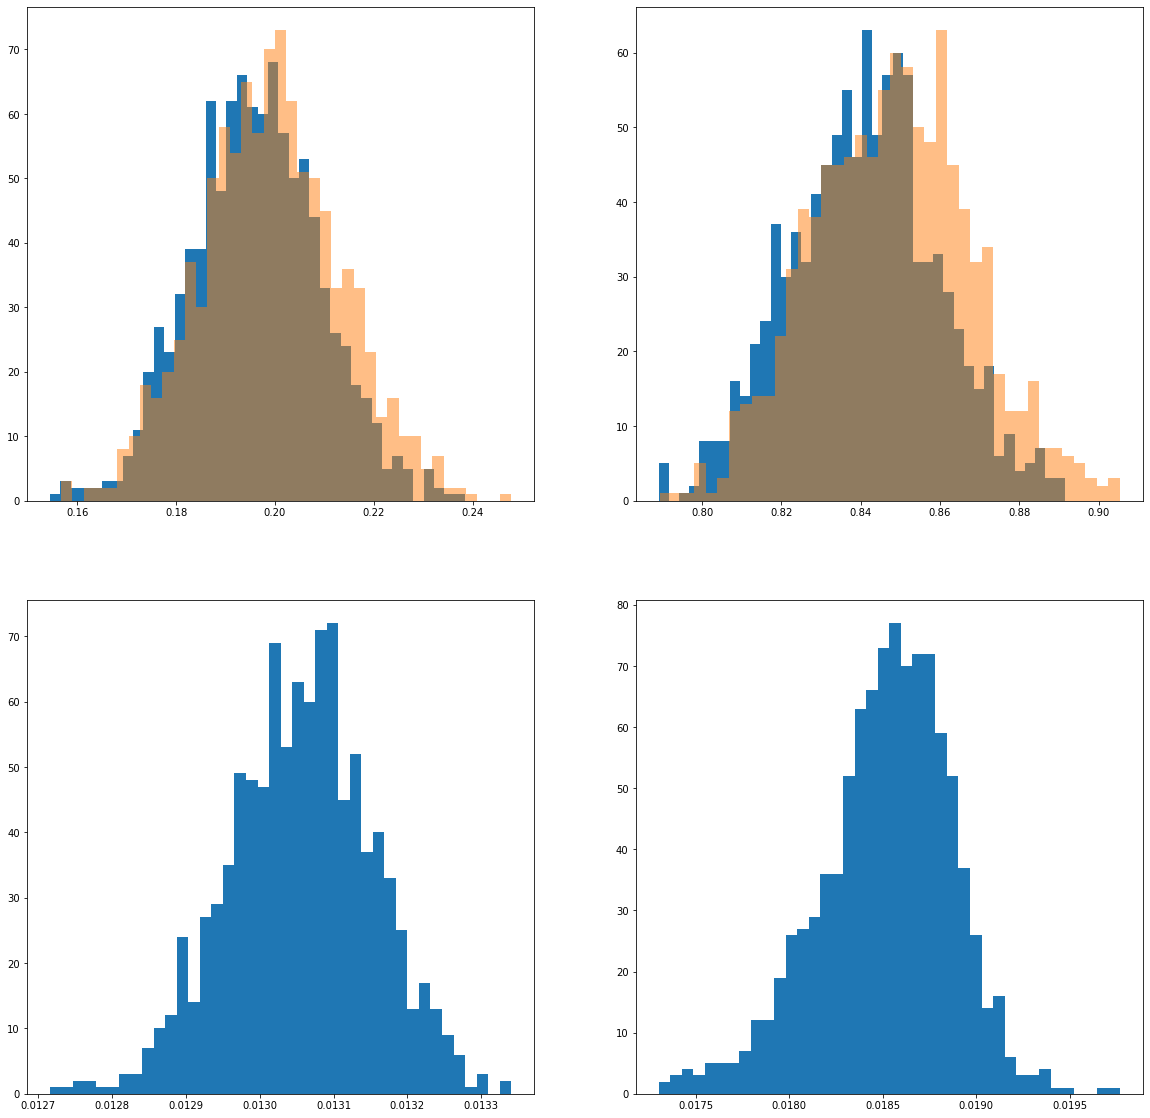

In [72]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [73]:



mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')






 mean:  0.1961, rms  0.0131, mean fit err  0.0131  |  diag. chi2 fit    0.1992, rms  0.0141, mean fit err  0.0071
 sig2:  0.8407, rms  0.0185, mean fit err  0.0185  |  diag. chi2 fit    0.8479, rms  0.0199, mean fit err  0.0097





<function matplotlib.pyplot.show(close=None, block=None)>

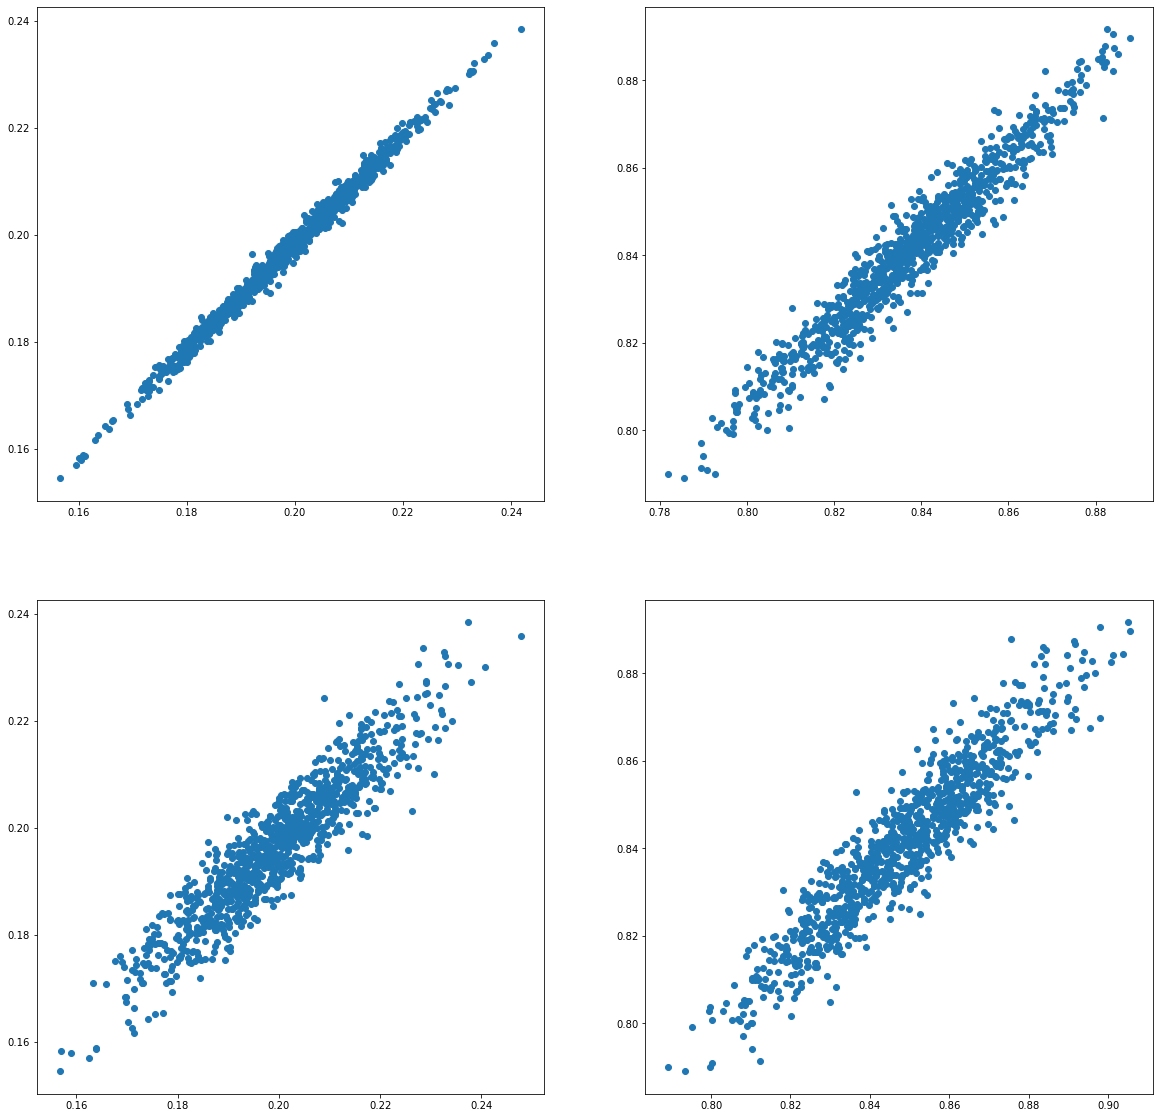

In [74]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].scatter( simple_calc_mean, chi2_fit_mu_val )
ax[0][1].scatter( simple_calc_cov, chi2_fit_sig2_val )

ax[1][0].scatter( chi2_fit_diag_mu_val, chi2_fit_mu_val )
ax[1][1].scatter( chi2_fit_diag_sig2_val, chi2_fit_sig2_val )

plt.show